In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Project/MusicalChordClassification


/content/drive/MyDrive/Project/MusicalChordClassification


In [3]:
import os
from matplotlib import pyplot as plt
import torch
import torchaudio
import numpy as np
import pandas as pd
from dataset_creater import *
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchaudio import load as torchaudio_load
from torchaudio.transforms import Resample, Spectrogram
from torch.utils.data import random_split
import seaborn as sns


In [4]:
DATASET_PATH = './data'

filename_MAJOR_FILE = os.path.join(DATASET_PATH, 'Major', 'Major_1.wav')
filename_MINOR_FILE = os.path.join(DATASET_PATH, 'Minor', 'Minor_1.wav')

def load_wav_16k_mono(filename):
    wave, sample_rate = torchaudio.load(filename, normalize=True)
    resample = Resample(orig_freq=sample_rate, new_freq=16000)
    wav = resample(wave)
    return wav.squeeze(0)

wave = load_wav_16k_mono(filename_MAJOR_FILE)
nwave = load_wav_16k_mono(filename_MINOR_FILE)

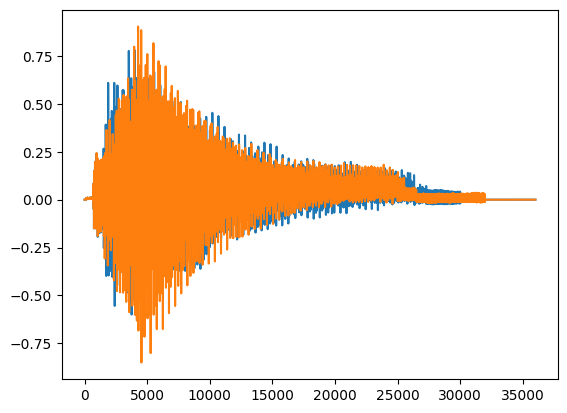

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()


In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchaudio import load as torchaudio_load
from torchaudio.transforms import Resample, Spectrogram
from torch.utils.data import random_split

def preprocess(file_path, label):
    # Load audio file and resample
    waveform, sample_rate = torchaudio_load(file_path, normalize=True)
    resample = Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resample(waveform)

    # Truncate or zero-pad to a length of 48000 samples
    waveform = waveform[:, :48000]
    if waveform.size(1) < 48000:
        zero_padding = torch.zeros(1, 48000 - waveform.size(1))
        waveform = torch.cat([zero_padding, waveform], dim=1)

    # Compute spectrogram
    spectrogram_transform = Spectrogram(
        n_fft=320,
        hop_length=32,
        center=False
    )
    spectrogram = spectrogram_transform(waveform)
    spectrogram = torch.abs(spectrogram)
    #pectrogram = spectrogram[:40]

    # Add channel dimension
    spectrogram = spectrogram.unsqueeze(0)

    return spectrogram, label

class AudioDataset(Dataset):
    def __init__(self, route, label):
        self.files = [os.path.join(route, file) for file in os.listdir(route) if file.endswith('.wav')]
        self.label = label
        self.transform = preprocess

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        waveform, _ = torchaudio_load(file_path, normalize=True)
        if self.transform:
            waveform, _ = self.transform(file_path, self.label)

        return waveform.squeeze(0), self.label

route_major_file = './data/Major'
route_minor_file = './data/Minor'

major_dataset = AudioDataset(route_major_file, label=1)
minor_dataset = AudioDataset(route_minor_file, label=0)

major_loader = DataLoader(major_dataset,  shuffle=True)
minor_loader = DataLoader(minor_dataset, shuffle=True)
datasets = ConcatDataset([major_dataset, minor_dataset])

from torch.utils.data import random_split

total_samples = len(datasets)
train_size = int(0.9 * total_samples)
val_size = int(0.10 * total_samples)
test_size = total_samples - train_size - val_size

# Randomly split the concatenated dataset
train_dataset, val_dataset, test_dataset = random_split(datasets, [train_size, val_size, test_size])

# Create dataloaders
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))



Train dataset size: 773
Validation dataset size: 85
Test dataset size: 1


In [7]:
import torch.nn as nn
from torch.nn.init import kaiming_normal_
from torchsummary import summary

class Audioclassifier(nn.Module):
    def __init__(self):
        super(Audioclassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3, 3), stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(186624, 128)
        self.relu = nn.ReLU()
        #self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(128, 2)
        # self.softmax = nn.Softmax()

        # Initialize linear layer weights using He initialization
        kaiming_normal_(self.fc1.weight)
        kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.conv2(x)
        #x = self.bn2(x)
        #x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x

# Instantiate the model
model = Audioclassifier()
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Print the model summary
summary(model, (1, 20, 650))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 18, 648]             160
       BatchNorm2d-2          [-1, 16, 18, 648]              32
              ReLU-3          [-1, 16, 18, 648]               0
           Flatten-4               [-1, 186624]               0
            Linear-5                  [-1, 128]      23,888,000
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 23,888,450
Trainable params: 23,888,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 5.70
Params size (MB): 91.13
Estimated Total Size (MB): 96.87
----------------------------------------------------------------


100%|██████████| 773/773 [00:44<00:00, 17.52it/s]


Epoch 1/20 => Train Loss: 1.4795, Train Acc: 0.5252, Val Loss: 0.7124, Val Acc: 0.5765


100%|██████████| 773/773 [00:37<00:00, 20.73it/s]


Epoch 2/20 => Train Loss: 1.1493, Train Acc: 0.6067, Val Loss: 0.6626, Val Acc: 0.6706


100%|██████████| 773/773 [00:38<00:00, 20.15it/s]


Epoch 3/20 => Train Loss: 1.2864, Train Acc: 0.6559, Val Loss: 1.6798, Val Acc: 0.6588


100%|██████████| 773/773 [00:39<00:00, 19.40it/s]


Epoch 4/20 => Train Loss: 1.4295, Train Acc: 0.7245, Val Loss: 1.5452, Val Acc: 0.6706


100%|██████████| 773/773 [00:36<00:00, 20.92it/s]


Epoch 5/20 => Train Loss: 1.1917, Train Acc: 0.7568, Val Loss: 1.5694, Val Acc: 0.6824


100%|██████████| 773/773 [00:41<00:00, 18.76it/s]


Epoch 6/20 => Train Loss: 0.9787, Train Acc: 0.7969, Val Loss: 1.3761, Val Acc: 0.7529


100%|██████████| 773/773 [00:37<00:00, 20.66it/s]


Epoch 7/20 => Train Loss: 0.7757, Train Acc: 0.8370, Val Loss: 1.3434, Val Acc: 0.7529


100%|██████████| 773/773 [00:38<00:00, 19.85it/s]


Epoch 8/20 => Train Loss: 0.5607, Train Acc: 0.8642, Val Loss: 1.5133, Val Acc: 0.7059


100%|██████████| 773/773 [00:37<00:00, 20.72it/s]


Epoch 9/20 => Train Loss: 0.4432, Train Acc: 0.9043, Val Loss: 1.3211, Val Acc: 0.7765


100%|██████████| 773/773 [00:38<00:00, 19.87it/s]


Epoch 10/20 => Train Loss: 0.3159, Train Acc: 0.9211, Val Loss: 1.1774, Val Acc: 0.8000


100%|██████████| 773/773 [00:37<00:00, 20.75it/s]


Epoch 11/20 => Train Loss: 0.2762, Train Acc: 0.9353, Val Loss: 1.0989, Val Acc: 0.8353


100%|██████████| 773/773 [00:37<00:00, 20.36it/s]


Epoch 12/20 => Train Loss: 0.2191, Train Acc: 0.9457, Val Loss: 1.5297, Val Acc: 0.8000


100%|██████████| 773/773 [00:37<00:00, 20.54it/s]


Epoch 13/20 => Train Loss: 0.1188, Train Acc: 0.9690, Val Loss: 0.9573, Val Acc: 0.8118


100%|██████████| 773/773 [00:39<00:00, 19.45it/s]


Epoch 14/20 => Train Loss: 0.1071, Train Acc: 0.9715, Val Loss: 1.0770, Val Acc: 0.8588


100%|██████████| 773/773 [00:38<00:00, 20.26it/s]


Epoch 15/20 => Train Loss: 0.1251, Train Acc: 0.9754, Val Loss: 0.9846, Val Acc: 0.8824


100%|██████████| 773/773 [00:37<00:00, 20.42it/s]


Epoch 16/20 => Train Loss: 0.1019, Train Acc: 0.9806, Val Loss: 1.3411, Val Acc: 0.8471


100%|██████████| 773/773 [00:38<00:00, 19.93it/s]


Epoch 17/20 => Train Loss: 0.0495, Train Acc: 0.9897, Val Loss: 1.5149, Val Acc: 0.8353


100%|██████████| 773/773 [00:36<00:00, 21.01it/s]


Epoch 18/20 => Train Loss: 0.0656, Train Acc: 0.9871, Val Loss: 1.3373, Val Acc: 0.8706


100%|██████████| 773/773 [00:39<00:00, 19.75it/s]


Epoch 19/20 => Train Loss: 0.0712, Train Acc: 0.9884, Val Loss: 1.4749, Val Acc: 0.8588


100%|██████████| 773/773 [00:37<00:00, 20.63it/s]


Epoch 20/20 => Train Loss: 0.1400, Train Acc: 0.9741, Val Loss: 1.6943, Val Acc: 0.8588
Confusion Matrix:
[[29  4]
 [ 8 44]]
F1 Score: 0.8800
Accuracy: 0.8588


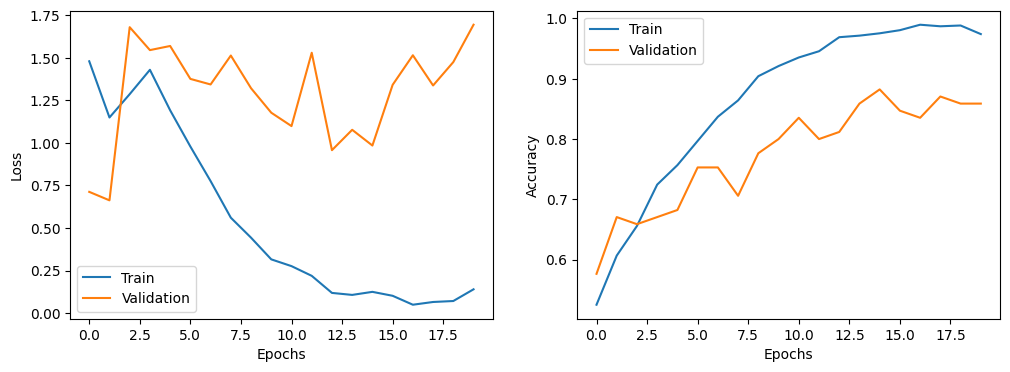

In [8]:
from sklearn.metrics import confusion_matrix, f1_score
import torch.optim as optim

# Define the loss function, optimizer, and other hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.000001)
#lambda_l1 = 0.001
num_epochs = 20  # Adjust as needed

train_losses, val_losses, train_acc, val_acc = [], [], [], []


from tqdm import tqdm


# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(train_loader):
        #for i in range(len(labels)):
        #  import pdb
        #  pdb.set_trace()
        #  inputs[i][0] = input[i][0][:40][200:]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()


        outputs = model(inputs[:, :, :20, 350:1000]) #[:, :, :20, 350:1000]
        loss = criterion(outputs, labels)

        '''
         # L1 regularization
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for name, param in model.named_parameters():
            if 'weight' in name:
                l1_reg = l1_reg + torch.norm(param, 1)

        # Add L1 regularization term to the loss
        loss = loss + lambda_l1 * l1_reg
        '''
        running_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        #for name, param in model.named_parameters():
        #  print(f"Parameter: {name}, Gradient: {param.grad}")
        #print(model.conv1.weight)
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)  # Append accuracy values

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            #for i in range(len(labels)):
            #  inputs[i] = input[i][0][:40][200:]
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs[:, :, :20, 350:1000]) #[:, :, :20, 350:1000]
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct_val / total_val
    val_acc.append(val_accuracy)  # Append accuracy values

    print(f"Epoch {epoch + 1}/{num_epochs} => "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")


# Test phase
model.eval()
all_labels, all_predictions = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        #for i in range(len(labels)):
        #      inputs[i] = input[i][0][:40][200:]
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs[:, :, :20, 350:1000]) #[:, :, :20, 350:1000]
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate confusion matrix and F1 score
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

print("Confusion Matrix:")
print(conf_matrix)
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot learning curve and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

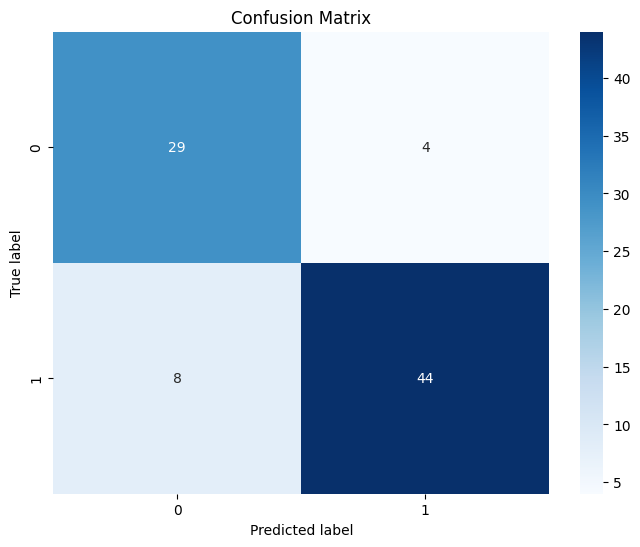

In [9]:
import seaborn as sns
# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()